In [97]:
import torch
import torch.nn as nn
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm
import quantecon as qe

# Set device - use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Model Parameters

In [98]:
# Preferences
beta = 0.9      # Discount factor
gamma = 2.0     # Risk aversion (CRRA)
r = (1/beta-1) * 0.9

# Income process (log-AR(1))
rho_Z = 0.9       # Persistence
sigma_Z = 0.2     # Shock standard deviation
mu_Z = np.exp(1/2 * sigma_Z**2 / (1 - rho_Z**2))

nA = 1000
Amin = 0.0
Amax = 5.0
A_grid = np.linspace(Amin, Amax, nA)

In [99]:
def coh_fun(Z, A):
    return A * (1+r) + Z

def c_fun(savings_rate, Z, A):
    """Consumption function given savings rate, TFP Z and assets A"""
    coh = coh_fun(Z, A)
    return (1 - savings_rate) * coh

In [100]:
class DecisionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), # two inputs 
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2) # two outputs
        )
        
    def forward(self, x):
        return self.net(x)


network = DecisionNetwork().to(device)

In [ ]:
def policy_function(Z, A):
    """Decision rule: maps states to savings rate"""
    
    # Normalize in log space for Z (log Z has mean 0, std = sigma_Z/sqrt(1-rho^2))
    sigma_log_Z = sigma_Z / np.sqrt(1 - rho_Z**2)
    log_Z_normalized = torch.log(Z) / sigma_log_Z / 2
    A_normalized = 2.0 * (A - Amin) / (Amax - Amin) - 1.0
    
    # Stack inputs: shape (n, 2)
    s = torch.stack([log_Z_normalized, A_normalized], dim=1)
    
    # Forward pass through network
    x = network(s)  # (n, 2)
    
    # Savings rate in [0,1]
    savings_rate = torch.sigmoid(x[:, 0])
    # Lagrange in [0,1]: lagrange=1 means unconstrained, <1 means constrained
    lagrange = torch.sigmoid(x[:, 1])
    
    return torch.clamp(savings_rate, max=0.999), lagrange

In [ ]:
# Here is the Fischer-Burmeister (FB) in PyTorch:
min_FB = lambda a,b: a+b-torch.sqrt(a**2+b**2)

def euler_residuals(Z, A, eps):
    # Current decisions
    savings_rate, lagrange = policy_function(Z, A)
    coh = coh_fun(Z, A)
    A_next = savings_rate * coh

    # Clamp A_next to valid asset range
    A_next = torch.clamp(A_next, min=Amin, max=Amax)

    C = coh - A_next
    Z_next = torch.exp(rho_Z * torch.log(Z) + eps)

    # Next-period policy and consumption (vectorized over shocks)
    savings_rate_next, _ = policy_function(Z_next, A_next)
    C_next = c_fun(savings_rate_next, Z_next, A_next)

    # Future returns and marginal utility (Monte Carlo expectation)
    MU_next = C_next**(-gamma)
    RHS = beta * MU_next * (1.0 + r) 
    
    # Original Euler: RHS/MU = lagrange (lagrange=1 when unconstrained)
    FOC = RHS / C**(-gamma) - lagrange
    slackness = min_FB(1-lagrange, savings_rate)
    return FOC, slackness

## Objective Function 

In [ ]:
def sample_Z_ergodic(n, rho, sigma_eps, *, device=None, dtype=torch.float32):
    if not (-1.0 < rho < 1.0):
        raise ValueError("Need |rho| < 1 for a stationary (ergodic) distribution.")
    device = device or torch.device("cpu")
    rho = torch.as_tensor(rho, device=device, dtype=dtype)
    sigma_eps = torch.as_tensor(sigma_eps, device=device, dtype=dtype)

    sigma_x = sigma_eps / torch.sqrt(1.0 - rho**2)          # std of log Z in stationarity
    x = sigma_x * torch.randn(n, device=device, dtype=dtype) # mean 0
    Z = torch.exp(x)
    return Z

def simulation(n=256, T = 10, epoch = 0, noise = 1e-3):
    """Simulate the model given initial assets A and TFP Z"""
    
    A_path = torch.zeros((T, n), device=device)
    Z_path = torch.zeros((T, n), device=device)
    
    # Fixed: Z from ergodic distribution, A from uniform on asset grid
    Z_path[0] = sample_Z_ergodic(n, rho_Z, sigma_Z, device=device)
    A_path[0] = torch.rand(n, device=device) * (Amax - Amin) + Amin

    if epoch < 50:
        return A_path[0], Z_path[0] 
    
    else:
        
        for t in range(T-1):
            A_torch = A_path[t].clone()
            Z_torch = Z_path[t].clone()
            
            savings_rate_0, _ = policy_function(Z_torch, A_torch) 
            savings_rate = savings_rate_0 + noise * torch.randn(n, device=device)
            coh = coh_fun(Z_torch, A_torch)
            A_next = savings_rate * coh
            
            # Update for next period
            A_path[t+1] = A_next
            eps = sigma_Z * torch.randn(n, device=device)
            Z_path[t+1] = torch.exp(rho_Z * torch.log(Z_path[t]) + eps)

        A_new = A_path[-1]
        Z_new = Z_path[-1]
        
    return A_new, Z_new

def objective_function(A, Z):
    """Loss on a batch of states (A, Z)."""
    n = A.shape[0]

    # Monte Carlo expectation with n_shocks draws per state
    eps1 = sigma_Z * torch.randn(n, device=device)
    FOC, slackness = euler_residuals(Z, A, eps1)

    return torch.mean(FOC**2 + slackness**2)

In [ ]:
base_lr = 1e-3

optimizer = torch.optim.Adam(network.parameters(), lr=base_lr)

n_batch = int(128 / 2)
n_sample = 2048
steps_per_epoch = 200
epochs = 500

def training_step(A_batch, Z_batch):
    optimizer.zero_grad()
    loss = objective_function(A_batch, Z_batch)
    loss.backward()
    optimizer.step()
    return loss.item()

def train_epochs(epochs, steps_per_epoch, n_sample, n_batch):
    vals = []
    for epoch in tqdm(range(epochs)):
        # Simulate a fresh sample each epoch
        with torch.no_grad():
            A_sample, Z_sample = simulation(epoch=epoch, n=n_sample, T=10)
        A_sample = A_sample.to(device)
        Z_sample = Z_sample.to(device)
        for _ in range(steps_per_epoch):
            idx = torch.randint(0, n_sample, (n_batch,), device=device)
            A_batch = A_sample[idx]
            Z_batch = Z_sample[idx]
            val = training_step(A_batch, Z_batch)
            vals.append(val)
    return vals

In [ ]:
results = train_epochs(epochs, steps_per_epoch, n_sample, n_batch)

  0%|          | 0/500 [00:00<?, ?it/s]/var/folders/hn/dsqvtr1n09z9k135wwh_g7280000gn/T/ipykernel_74145/480074780.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_torch = torch.tensor(A_path[t], device=device, dtype=torch.float32)
/var/folders/hn/dsqvtr1n09z9k135wwh_g7280000gn/T/ipykernel_74145/480074780.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z_torch = torch.tensor(Z_path[t], device=device, dtype=torch.float32)
 75%|███████▌  | 375/500 [01:07<00:23,  5.38it/s]

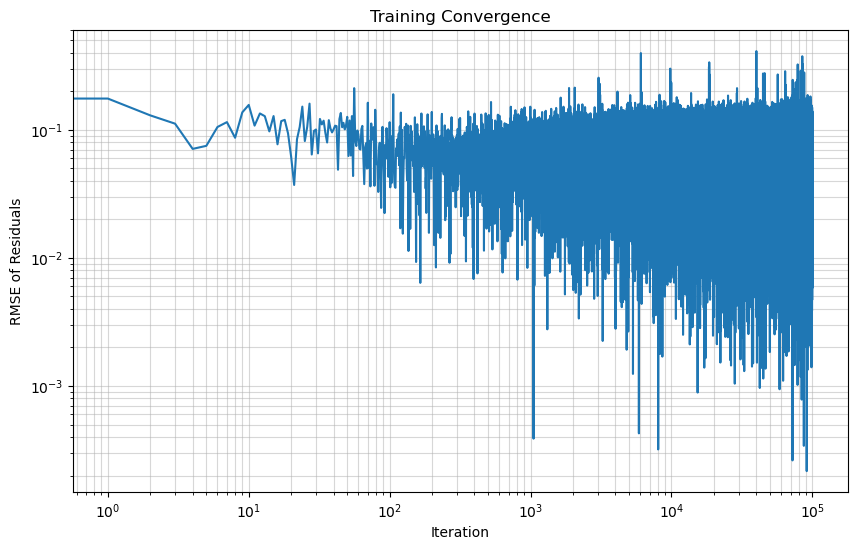

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(np.abs(results)))  # abs() for numerical safety
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('RMSE of Residuals')
plt.title('Training Convergence')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

## Learned Decision Rule

In [ ]:
from consav_vfi import vfi, A_grid as A_grid_vfi

_, policy_A = vfi(tol = 1e-6, max_iter = 1000, verbose = True)

Iteration 1: max value function diff = 4.70548513
Iteration 2: max value function diff = 3.12288521
Iteration 3: max value function diff = 2.17572446
Iteration 4: max value function diff = 1.56294072
Iteration 5: max value function diff = 1.14628756
Iteration 6: max value function diff = 0.85368516
Iteration 7: max value function diff = 0.64359856
Iteration 8: max value function diff = 0.49000573
Iteration 9: max value function diff = 0.37624950
Iteration 10: max value function diff = 0.29106889
Iteration 11: max value function diff = 0.22670018
Iteration 12: max value function diff = 0.17767238
Iteration 13: max value function diff = 0.14007179
Iteration 14: max value function diff = 0.11105197
Iteration 15: max value function diff = 0.08852314
Iteration 16: max value function diff = 0.07093717
Iteration 17: max value function diff = 0.05713566
Iteration 18: max value function diff = 0.04624821
Iteration 19: max value function diff = 0.03761621
Iteration 20: max value function diff = 

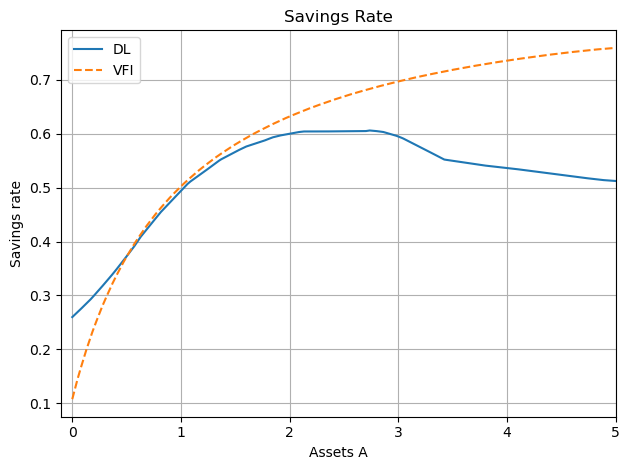

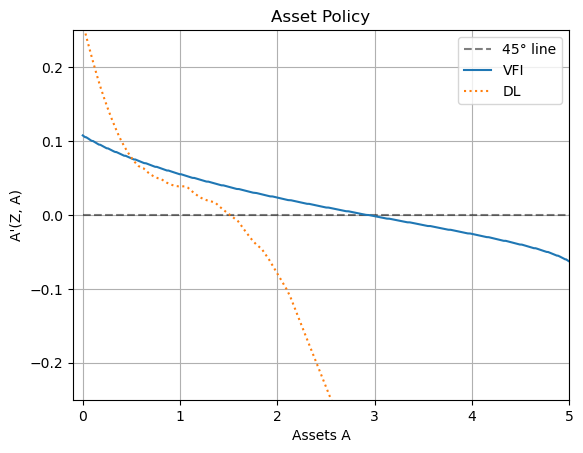

In [ ]:
with torch.no_grad():
    A_grid = torch.tensor(A_grid, dtype=torch.float32, device=device)
    ones = torch.ones_like(A_grid)  # Z = 1 (level value at steady state)
    savings_rate_vec, _ = policy_function(ones, A_grid)

# VFI savings rate for a representative Z index
coh_vfi = A_grid * (1 + r) + 1.0 
savings_rate_vfi = policy_A[4, :] / coh_vfi

plt.plot(A_grid.cpu(), savings_rate_vec.cpu(), label='DL')
plt.plot(A_grid, savings_rate_vfi, linestyle='--', label='VFI')
plt.xlabel("Assets A")
plt.ylabel("Savings rate")
plt.title("Savings Rate")
plt.xlim(-0.1, Amax)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

coh = coh_fun(ones, A_grid)
A_next_dl = savings_rate_vec * coh
A_next_vfi = policy_A[4, :]

plt.plot(A_grid.cpu(), np.zeros_like(A_grid.cpu()), 'k--', alpha=0.5, label='45° line')
plt.plot(A_grid_vfi, A_next_vfi - A_grid_vfi, label='VFI')
plt.plot(A_grid.cpu(), A_next_dl.cpu() - A_grid.cpu(), label='DL', linestyle=':')
plt.xlabel('Assets A')
plt.ylabel("A'(Z, A)")
plt.title('Asset Policy')
plt.xlim(-0.1, Amax)
plt.ylim(-0.25, 0.25)
plt.legend()
plt.grid()
plt.show()